# MRF Estimation.  

**This notebook is the first implementation of a segmented MRFs **




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [16]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from glob import glob
from scipy.signal import windows
from scipy.io import wavfile
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound
from soundsig.sound import spec_colormap

# strfpy
sys.path.append("/Users/frederictheunissen/Code/strfPy/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

Set up the path

In [3]:
# Change these paths to point at your data and stimulus directories
path_base = os.path.join('/Users/frederictheunissen/Code/strfPy')
# dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
dataDir = '/Users/frederictheunissen/Documents/Classes/Summer Course - Boot Camp/2016/theunissen_tutorials/data'
stimsDir = os.path.join(dataDir, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [4]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_good'
cellDir = os.path.join(dataDir, cellDirName, 'conspecific')


In [5]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [6]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [7]:
# Make a directory to save figures
figDir = os.path.join(cellStimDir, 'figures')
os.makedirs(figDir, exist_ok=True)

In [8]:
# set up datasets
srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)
pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']


### Generate the stimulus and response feature
The stimulus features are the MPS obtained for each song segment.  The song segments are obtained using a hard threshold and then merging short silences and short sounds.
The response feature is the PSTH smoothed with a hanning window.

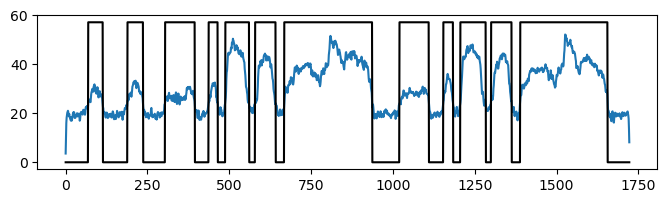

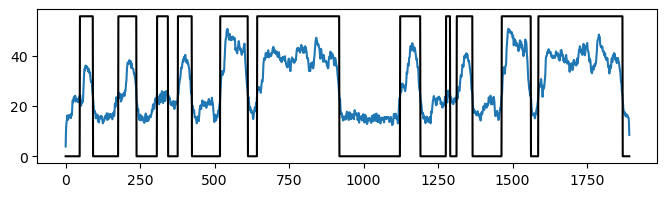

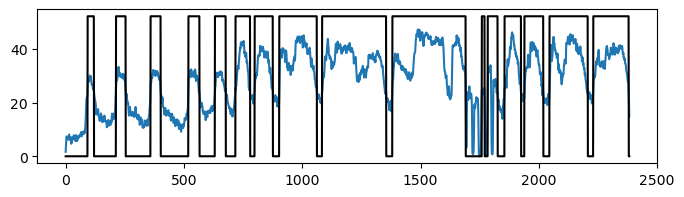

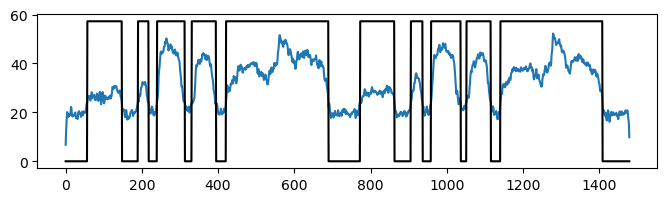

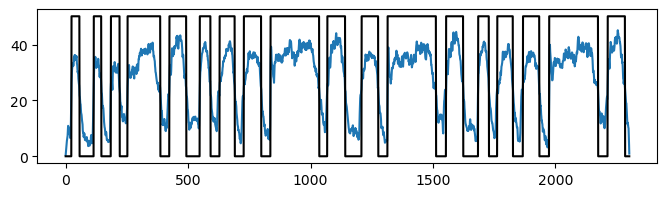

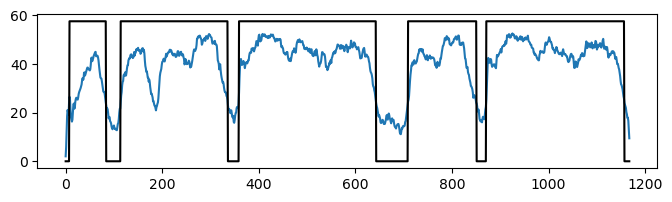

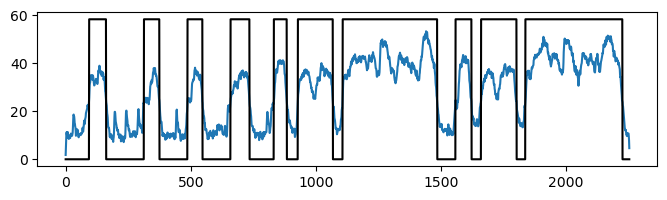

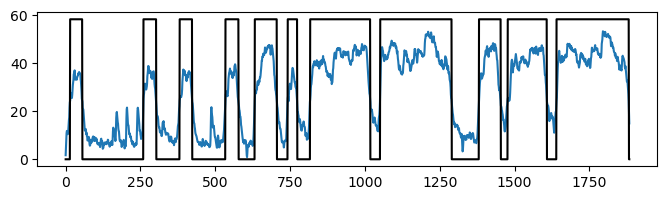

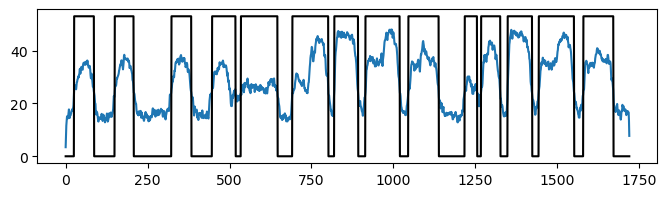

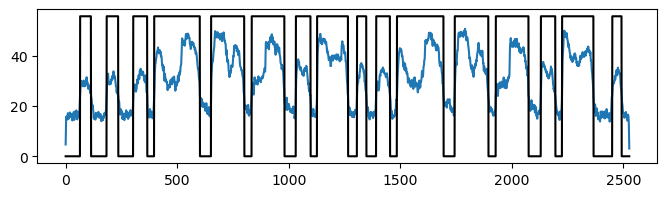

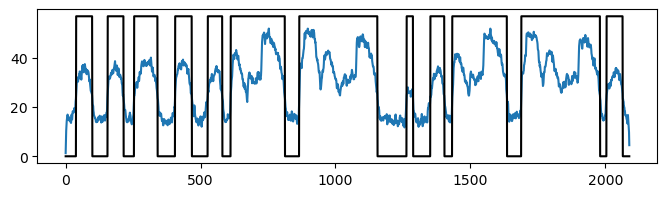

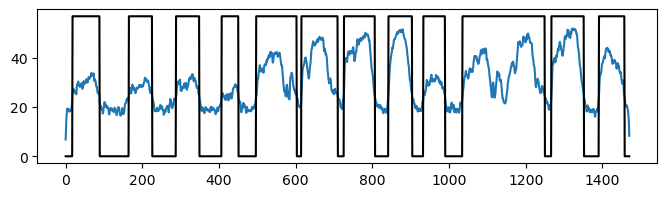

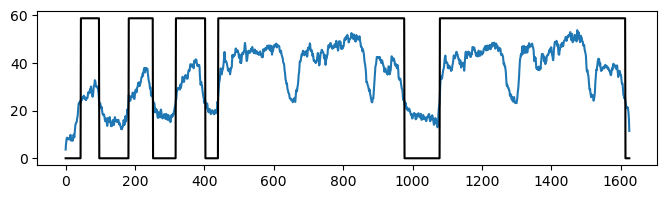

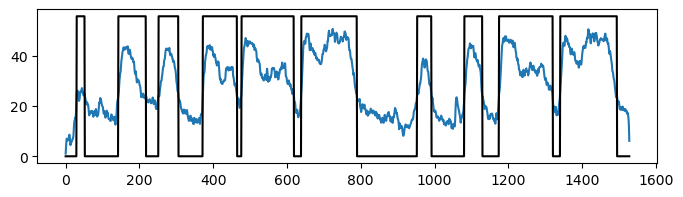

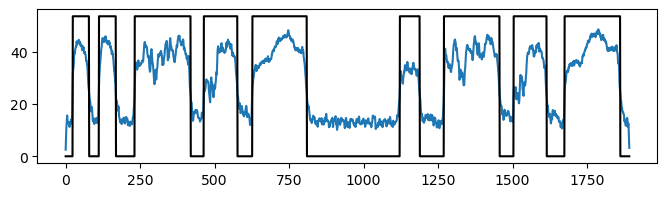

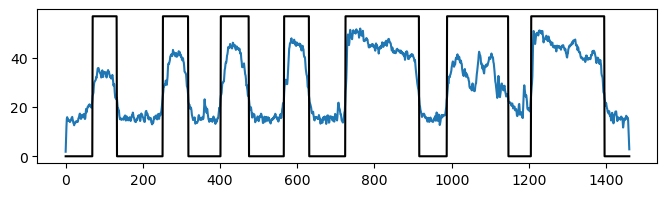

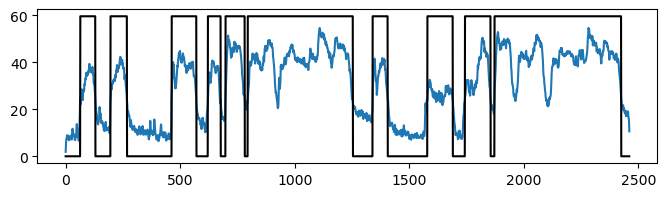

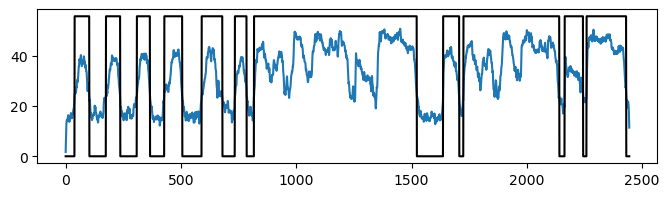

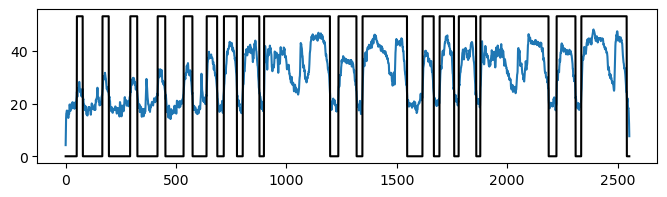

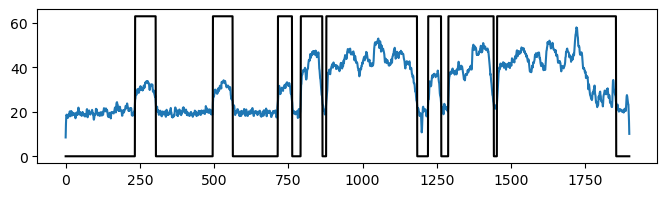

In [9]:
ampThresh = 24.0  # Threshold in dB where 50 is max
minSilence = 10  # Minimum length of silence in points - time units given by stim sample rate
minSound = 10  # Minimum length of sound in points
segmentBuffer = 25 # Number of points on each side of segment for response and MPS - time units given by stim sample rate
respChunkLen = 250 # Response length in number of points 

wHann = windows.hann(21, sym=True)   # The 21 ms (number of points) hanning window used to smooth the PSTH

stimMPS = []
respMPS = []
chunkID = {'set': [], 'indZero': [], 'indStart' : [], 'indEnd' : [], 'respIndStart' : [], 'respIndEnd' : []}



for iSet in range(pairCount) :

    # Stimulus wave file and amplitude enveloppe from spectrogram
    waveFile = srData['datasets'][iSet]['stim']['rawFile']
    fs , soundStim = wavfile.read(waveFile)
    soundLen = soundStim.size
    ampenv = np.mean(srData['datasets'][iSet]['stim']['tfrep']['spec'], axis=0)
    ampfs = srData['datasets'][iSet]['stim']['sampleRate']


    plt.figure(figsize=(8,2), dpi=100)
    plt.plot(ampenv)
    # plt.axhline(ampThresh, color = 'r')

    # Make a threshold
    soundOn = np.ones(ampenv.shape)
    soundOn[ampenv < ampThresh] = 0

    # Find edges and remove silences below 10 ms
    edges = soundOn[1:]-soundOn[0:-1]
    silBeg = np.argwhere(edges == -1)+1
    silEnd = np.argwhere(edges == 1)

    for silStart in silBeg:
        silFinish = np.argwhere(silEnd >= silStart)
        if silFinish.shape[0]:
            dt = silEnd[silFinish[0][0]]-silStart
            # print (silStart, silEnd[silFinish[0][0]], dt)   
            if dt < minSilence:
                # print(int(silStart), int(silEnd[silFinish[0][0]]+1))
                soundOn[int(silStart):int(silEnd[silFinish[0][0]]+1)] = 1.0

    # Remove sounds shorter than 10 ms
    edges = soundOn[1:]-soundOn[0:-1]
    soundEnd = np.argwhere(edges == -1)
    soundBeg = np.argwhere(edges == 1)+1

    for soundStart in soundBeg:
        soundFinish = np.argwhere(soundEnd >= soundStart)
        if soundFinish.shape[0]:
            dt = soundEnd[soundFinish[0][0]]-soundStart
            # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
            if dt < minSound:
                # print(int(soundStart), int(soundEnd[soundFinish[0][0]]+1))
                soundOn[int(soundStart):int(soundEnd[soundFinish[0][0]]+1)] = 0

    
    # Recalculate Edges
    edges = soundOn[1:]-soundOn[0:-1]
    soundEnd = np.argwhere(edges == -1)
    soundBeg = np.argwhere(edges == 1)+1

    for soundStart in soundBeg:
        soundFinish = np.argwhere(soundEnd >= soundStart)
        if soundFinish.shape[0]:
            dt = soundEnd[soundFinish[0][0]]-soundStart
            # print (soundStart, soundEnd[soundFinish[0][0]], dt)   
            if dt < minSound:
                print('WARNING - not expecting short sound here', int(soundStart), int(soundEnd[soundFinish[0][0]]+1))


    plt.plot(soundOn*(np.max(ampenv)+5), 'k')

    # Plot response
    resp = srData['datasets'][iSet]['resp']['psth']
    respSmoothed = np.convolve(resp, wHann, mode='same')
    respDataLen = respSmoothed.shape[0]

    # plt.plot(respSmoothed*np.max(ampenv)/np.max(respSmoothed), 'r')
    if iSet == 2:
        plt.savefig(os.path.join(figDir, 'song_segment.eps'))

    # Extract the MPS for each edge use 25 ms on each side as buffer
    for soundStart in soundBeg:
        soundFinish = np.argwhere(soundEnd >= soundStart)
        if soundFinish.shape[0]:

            # First estimate MPS for chunk
            indStart = int((soundStart-segmentBuffer)*fs/ampfs)
            if indStart < 0 :
                indStart = 0
            indEnd = int((soundEnd[soundFinish[0][0]]+segmentBuffer)*fs/ampfs)
            if indEnd >= soundLen:
                indEnd = soundLen - 1

            wavSound = soundStim[indStart:indEnd+1]

            # Create BioSound Object and calculate basic sound features
            myBioSound = BioSound(soundWave=wavSound, fs=fs, emitter='STRF', calltype = 'song')
            myBioSound.spectroCalc(spec_sample_rate=1000, freq_spacing = 50, min_freq=0, max_freq=10000)
            myBioSound.rms = myBioSound.sound.std() 
            myBioSound.ampenv(cutoff_freq = 20, amp_sample_rate = 1000)
            myBioSound.spectrum(f_high=10000)
            myBioSound.mpsCalc(window=0.05, Norm = True)  # Norm equals true normalizes the spectrogram but not the MPS
        
            # Store in list
            stimMPS.append(myBioSound.mps)

            # Now extract response for the same chunk.
            respChunk = np.zeros(respChunkLen)
            indZero = int(soundStart)
 
            indEnd = int((soundEnd[soundFinish[0][0]]+segmentBuffer))
            if indEnd > respDataLen:
                indEnd = respDataLen
            respIndEnd = segmentBuffer + (indEnd-indZero)
            if respIndEnd > respChunkLen:
                respIndEnd = respChunkLen
                indEnd = indZero + (respIndEnd-segmentBuffer)

            respChunk[segmentBuffer:respIndEnd] = respSmoothed[indZero:indEnd]

            respIndStart = 0
            indStart = indZero - segmentBuffer
            if indStart < 0:
                indStart = 0
                respIndStart = segmentBuffer - indZero

            respChunk[respIndStart:segmentBuffer] = respSmoothed[indStart:indZero]

            respMPS.append(respChunk)
            chunkID['set'].append(iSet)
            chunkID['indStart'].append(indStart)
            chunkID['indZero'].append(indZero)
            chunkID['indEnd'].append(indEnd)
            chunkID['respIndStart'].append(respIndStart)
            chunkID['respIndEnd'].append(respIndEnd)




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.20155362 0.1262417  0.09078541 0.06611672 0.05960379 0.04845066
 0.04514611 0.03796561 0.03364756 0.03080956]


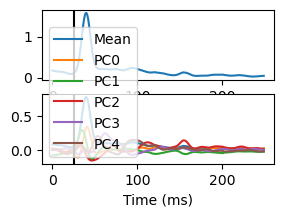

In [10]:
# Plot the mean responsem and the PCs

# Mean Response
respMPS = np.array(respMPS)
plt.figure(figsize = (3,2), dpi=100)
plt.subplot(2,1,1)
plt.plot(respMPS.mean(axis=0))
plt.axvline(segmentBuffer, color = 'k')

# Calculate the PCs
pcResp = PCA(n_components=10)
respPC = pcResp.fit_transform(respMPS)
print(pcResp.explained_variance_ratio_)

# Plot the PCs
plt.subplot(2,1,2)
plt.plot(pcResp.mean_*.5, label='Mean')
for iPC in range(5):
    plt.plot(pcResp.components_[iPC,:], label='PC%d'%(iPC))
plt.axvline(segmentBuffer, color = 'k')
plt.xlabel('Time (ms)')
plt.legend()

plt.savefig(os.path.join(figDir, 'RespPCs.eps'))


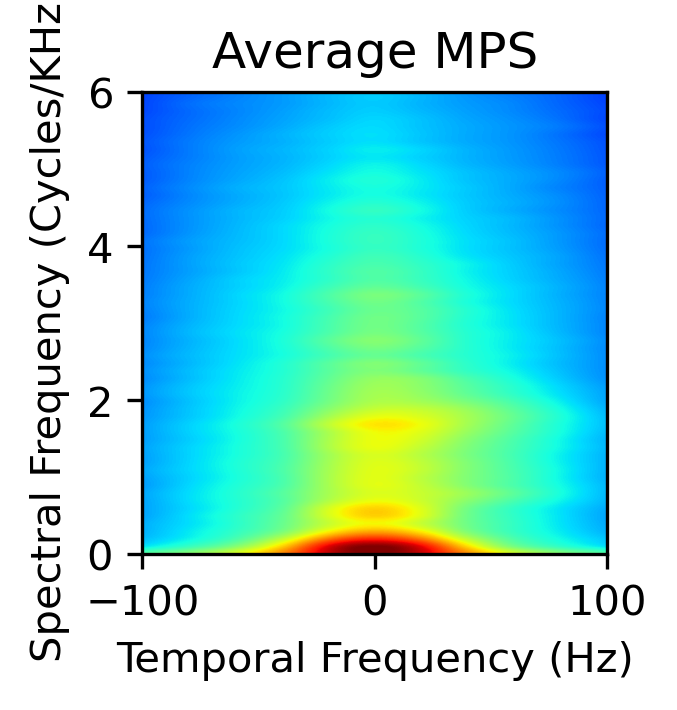

In [11]:
# Plot the average MPS.

wt = myBioSound.wt
wf = myBioSound.wf

stimMPS = np.array(stimMPS)
mpsAVG = stimMPS.mean(axis=0)

DBNOISE = 50
plt.figure(dpi=300, figsize=(2,2))
cmap = plt.get_cmap('jet')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
logMPS = 10.0*np.log10(mpsAVG)
maxMPS = logMPS.max()
minMPS = maxMPS-DBNOISE
logMPS[logMPS < minMPS] = minMPS
plt.imshow(logMPS, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')

plt.ylim((0,6))
plt.xlim((-100, 100))
plt.title('Average MPS')
plt.savefig(os.path.join(figDir, 'StimMPS.eps'))

set up strflab

In [12]:
# Use center of MPS for feature

# Find the indices of the center
indwt = np.argwhere((wt > -100) & (wt < 100))
indwf = np.argwhere( (wf >= 0) & (wf <6e-3))

stimMPSFeat = stimMPS[:,int(indwf[0]):int(indwf[-1]+1),int(indwt[0]):int(indwt[-1]+1)].reshape(stimMPS.shape[0], len(indwt)*len(indwf))

stimMPSFeat = stimMPSFeat - stimMPSFeat.mean(axis=0)

In [13]:
# Perform cross-validated ridge regression for all PCs
Alphas = (1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10)   # Ridge hyperparameter coeffiecients
nPC = respPC.shape[1]

# Allocate space for predictions
respPCPred = np.zeros(respPC.shape)
r2PC = np.zeros(nPC)
MRF = np.zeros((nPC, stimMPSFeat.shape[1]))


for iPC in range(nPC):
    clf = RidgeCV(alphas=Alphas)
    clf.fit(stimMPSFeat, respPC[:,iPC])
    respPCPred[:,iPC] = clf.predict(stimMPSFeat)
    r2PC[iPC] = clf.score(stimMPSFeat, respPC[:,0])
    MRF[iPC,:] = clf.coef_

    print('PC %d: Best alpha = %g R2 = %.3f' % (iPC, clf.alpha_, r2PC[iPC]))


PC 0: Best alpha = 1e+07 R2 = 0.350
PC 1: Best alpha = 100000 R2 = -0.320
PC 2: Best alpha = 100000 R2 = -0.101
PC 3: Best alpha = 1e+06 R2 = -0.018
PC 4: Best alpha = 1e+06 R2 = 0.007
PC 5: Best alpha = 1e+08 R2 = -0.002
PC 6: Best alpha = 1e+06 R2 = -0.019
PC 7: Best alpha = 1e+07 R2 = -0.038
PC 8: Best alpha = 1e+06 R2 = -0.006
PC 9: Best alpha = 1e+06 R2 = -0.067


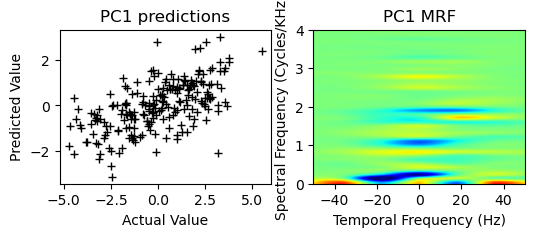

In [14]:
# Plot predictions and MRF for first PC

plt.figure(figsize=(6,2), dpi = 100)

plt.subplot(1,2,1)
plt.plot(respPC[:,0], respPCPred[:,0], 'k+')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('PC1 predictions')

plt.subplot(1,2,2)
MRFPlot = MRF[0,:].reshape(len(indwf), len(indwt))
maxabs = np.max((MRFPlot.max(), -MRFPlot.min()))
cmap = plt.get_cmap('jet')
ex = (wt[indwt].min(), wt[indwt].max(), wf[indwf].min()*1e3, wf[indwf].max()*1e3)
plt.imshow(MRFPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.title('PC1 MRF')


plt.ylim((0,4))
plt.xlim((-50, 50))
plt.clim((-maxabs*0.8, maxabs*0.8))

plt.savefig(os.path.join(figDir, 'PC1_MRF.eps'))



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


A colormap named "SpectroColorMap" is already registered.


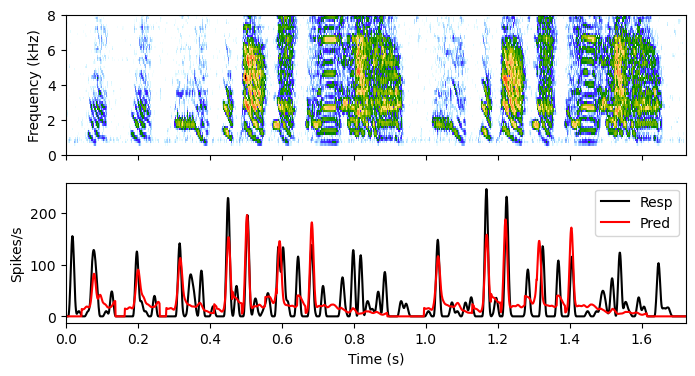

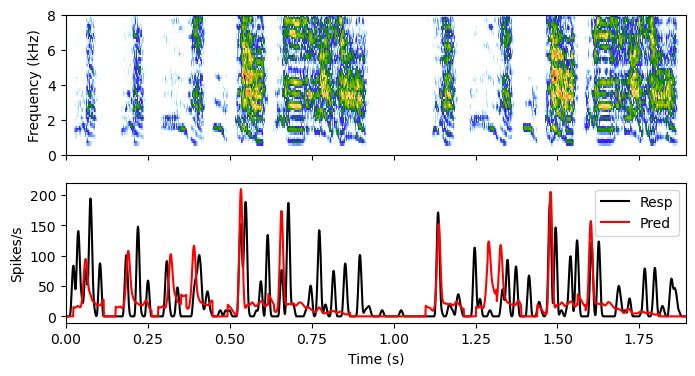

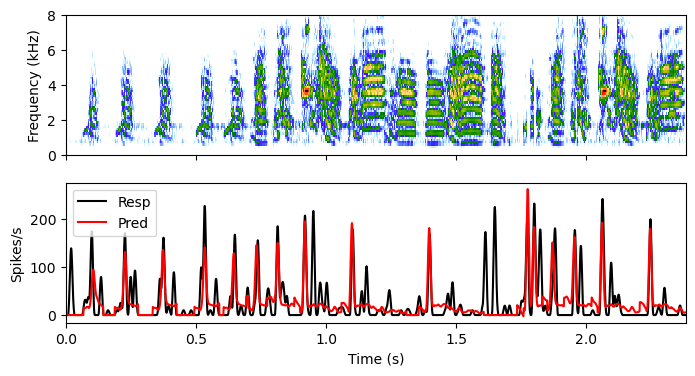

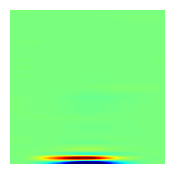

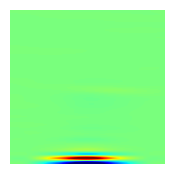

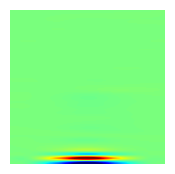

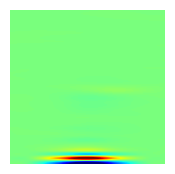

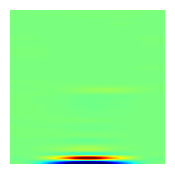

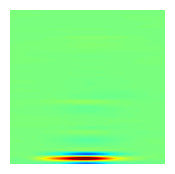

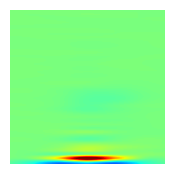

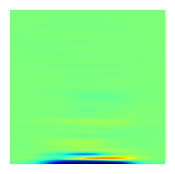

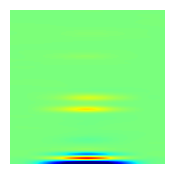

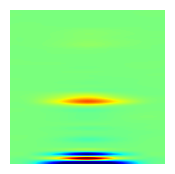

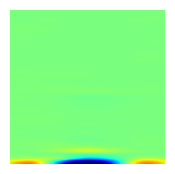

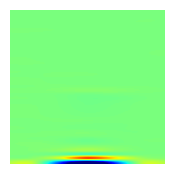

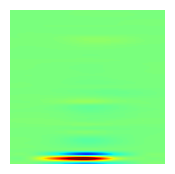

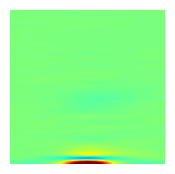

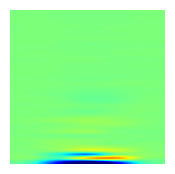

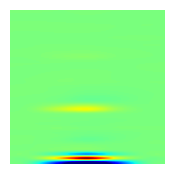

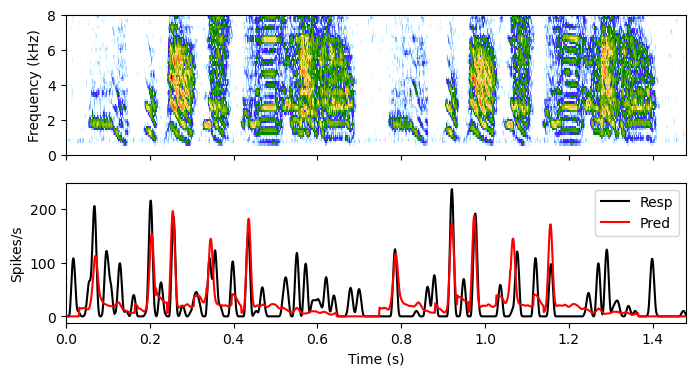

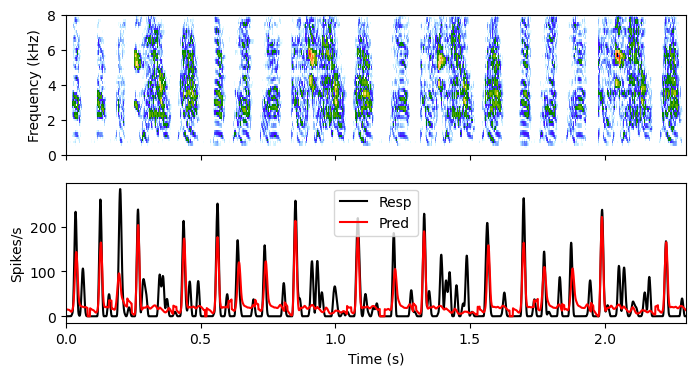

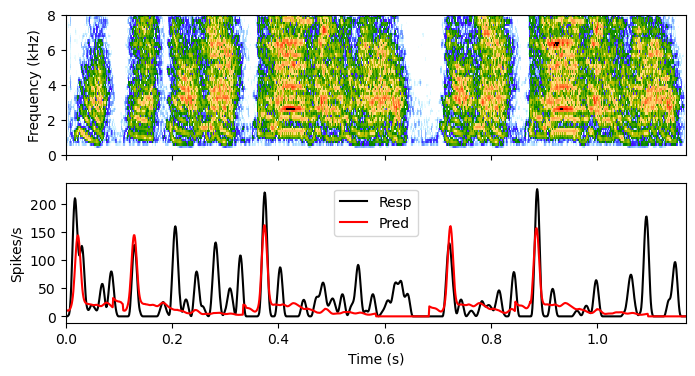

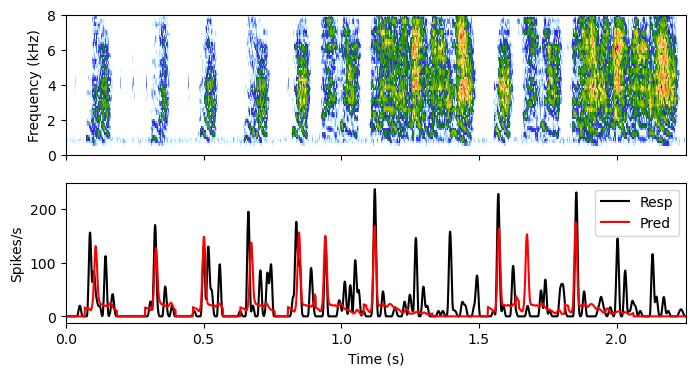

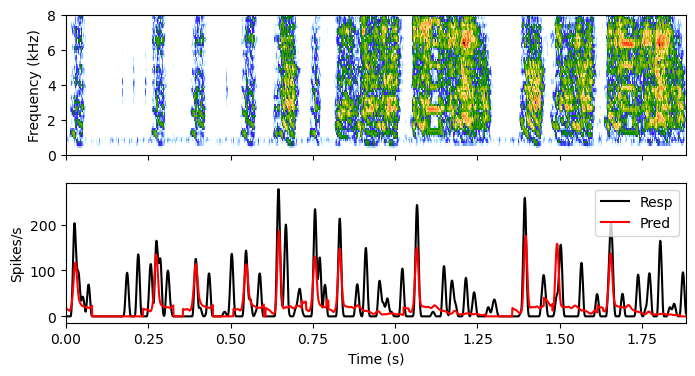

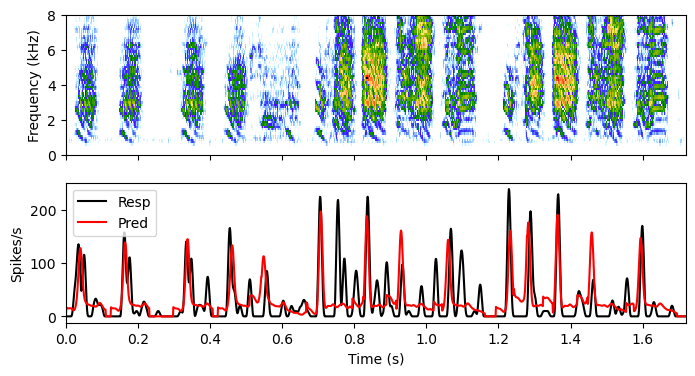

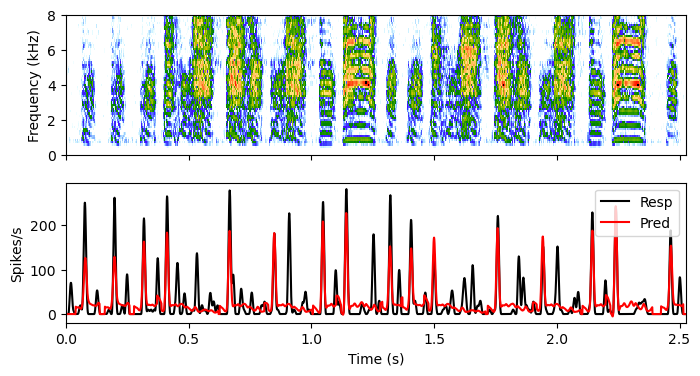

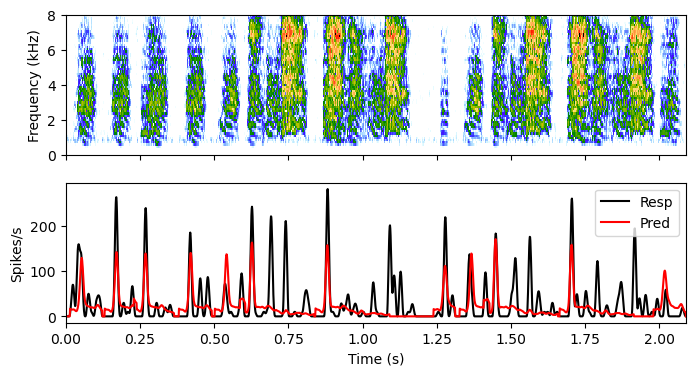

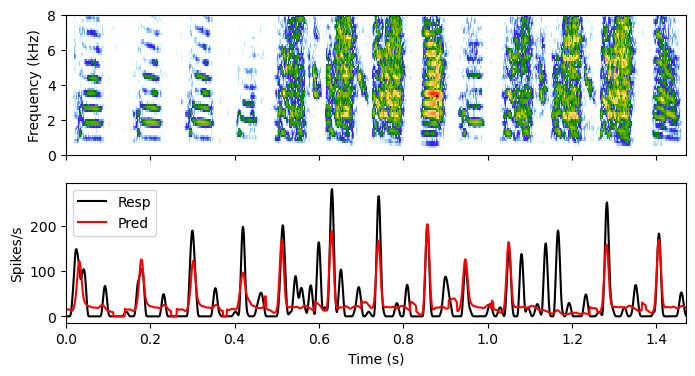

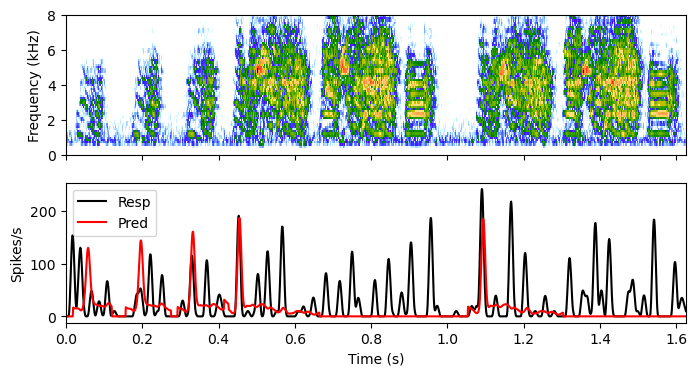

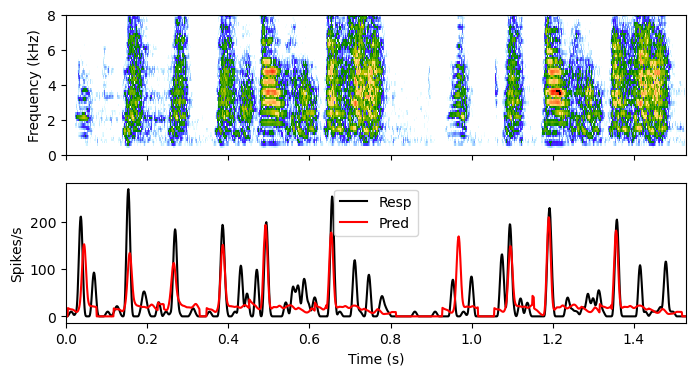

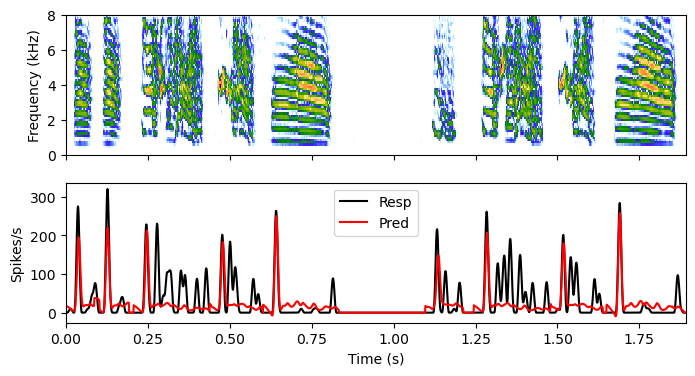

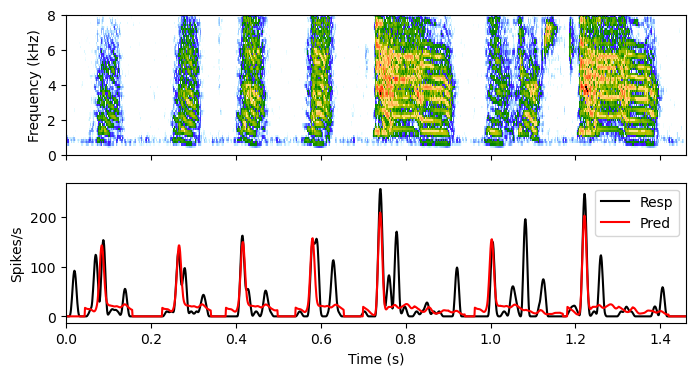

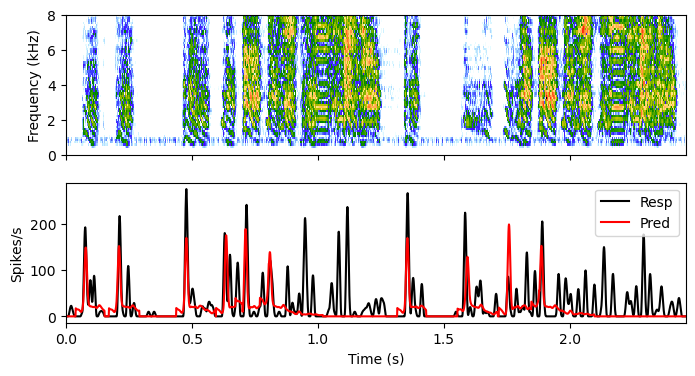

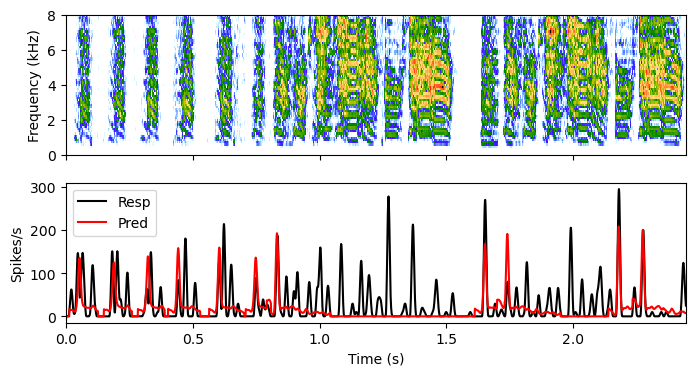

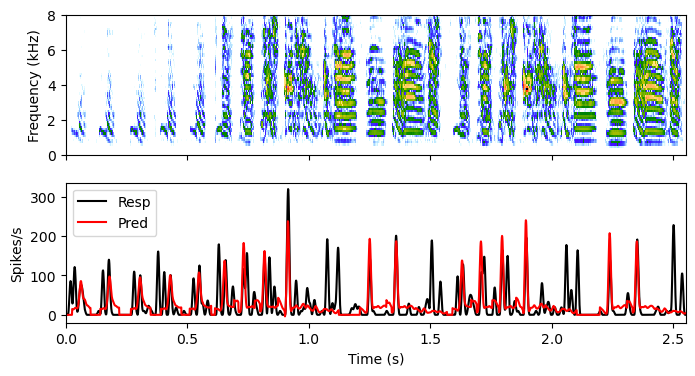

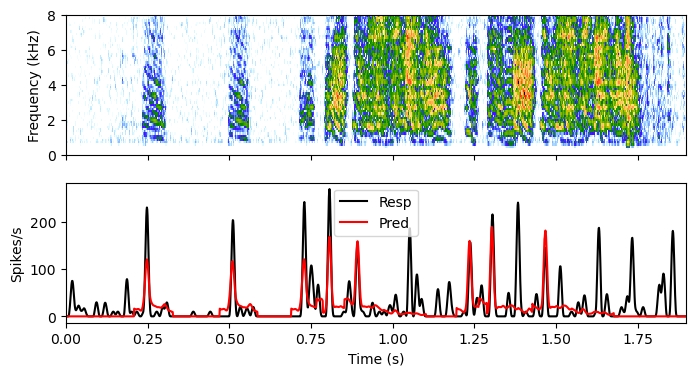

In [15]:
# Generate, Store and Plot the Predictions by rejoining the predictions for each segment.
# Note that we are only using the positive R2

# Making variables for the concatenated predictions
concatPredResp = np.array([])
concatResp = np.array([])

# We are calculating these for a coherence estimation but this is not happening yet.
concatPsthHalf1 = np.array([])
concatPsthHalf2 = np.array([])
pairCountTrials = np.zeros(pairCount)

nChunk = len(respMPS)
DBNOISE = 50  # Color Threshold for spectrogram


# Color map for spectrograms
spec_colormap()   # defined in sound.py

for iSet in range(pairCount) :

    # Get the stimulus (spectrogram) and the response
    ds = srData['datasets'][iSet]
    resp = ds['resp']['psth']
    tfrep = ds['stim']['tfrep']
    respSmoothed = np.convolve(resp, wHann, mode='same')
    
    # Generate the prediction
    respPrediction = np.zeros(respSmoothed.shape)
    for iChunk in range(nChunk):
        if (chunkID['set'][iChunk] == iSet):
            
            # Start the prediction with the mean PC
            respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
            respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
            
            # Now add contribution of each PC fit if R2 above threshold
            for iPC in range(nPC):
                if (r2PC[iPC] > 0.01) :
                    respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                    respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]

    
    # Store the prediction and the actual response in a single vector to calculate predition quality
    concatPredResp = np.concatenate((concatPredResp, respPrediction))
    concatResp = np.concatenate((concatResp, respSmoothed))

    # Get raw spike data divided into two for coherency calculations
    psthdata = preprocSound.split_psth(ds['resp']['rawSpikeIndicies'], resp.shape[0])
    concatPsthHalf1 = np.concatenate((concatPsthHalf1, psthdata['psth_half1']))
    concatPsthHalf2 = np.concatenate((concatPsthHalf2, psthdata['psth_half2']))
    numTrials = len(ds['resp']['rawSpikeTimes'])  # One needs to check that all numTrials are equal
    pairCountTrials[iSet] = numTrials
    
    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

    # The spectrogram
    soundSpect = np.copy(tfrep['spec'])
    maxB = soundSpect.max()
    minB = maxB-DBNOISE
    soundSpect[soundSpect < minB] = minB
    minSpect = soundSpect.min()
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    # ax1.set_xlabel('Time (s)')

    # The prediction
    fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
    ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
    ax2.plot(tfrep['t'], respPrediction*fac, 'r', label='Pred')
    ax2.set_ylabel('Spikes/s')
    ax2.set_xlabel('Time (s)')
    plt.legend()

    if iSet  == 2 :
        plt.savefig(os.path.join(figDir, 'stimRespMRFPred%d.eps' % (iSet)))
        for iChunk in range(nChunk):
            if (chunkID['set'][iChunk] == iSet):
                plt.figure(figsize=(2,2), dpi = 100)
                MPSPlot = stimMPSFeat[iChunk,:].reshape(len(indwf), len(indwt))
                maxabs = np.max((MPSPlot.max(), -MPSPlot.min()))
                cmap = plt.get_cmap('jet')
                ex = (wt[indwt].min(), wt[indwt].max(), wf[indwf].min()*1e3, wf[indwf].max()*1e3)
                plt.imshow(MPSPlot, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex)
                
                plt.ylim((0,4))
                plt.xlim((-50, 50))
                plt.clim((-maxabs*0.8, maxabs*0.8))
                plt.axis('off')
                plt.savefig(os.path.join(figDir, 'stimMPSChunk%d_%d.eps' % (iSet, iChunk)))

 
            



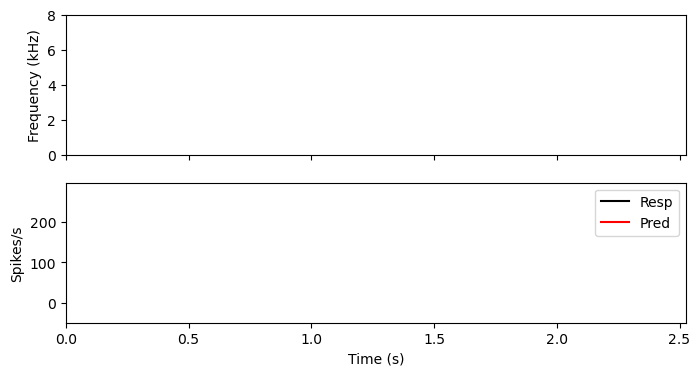

In [41]:
# Add an animation
nChunk = len(respMPS)
DBNOISE = 50  # Color Threshold for spectrogram
iSet = 9      # The one to plot/animate

# Color map for spectrograms
spec_colormap()   # defined in sound.py

# Get the stimulus (spectrogram) and the response
ds = srData['datasets'][iSet]
resp = ds['resp']['psth']
tfrep = ds['stim']['tfrep']
numTrials = len(ds['resp']['rawSpikeTimes']) 
respSmoothed = np.convolve(resp, wHann, mode='same')
    
# Generate the prediction
respPrediction = np.zeros(respSmoothed.shape)
for iChunk in range(nChunk):
    if (chunkID['set'][iChunk] == iSet):       
        # Start the prediction with the mean PC
        respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
        respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
            
        # Now add contribution of each PC fit if R2 above threshold
        for iPC in range(nPC):
            if (r2PC[iPC] > 0.01) :
                respPrediction[chunkID['indZero'][iChunk]:chunkID['indEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                respPrediction[chunkID['indStart'][iChunk]:chunkID['indZero'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]


allArtists = [] 
# Plot the spectrogram and the prediction
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))

# The spectrogram
soundSpect = np.copy(tfrep['spec'])
maxB = soundSpect.max()
minB = maxB-DBNOISE
soundSpect[soundSpect < minB] = minB
minSpect = soundSpect.min()
cmap = plt.get_cmap('SpectroColorMap')
    
imag1 = ax1.imshow(soundSpect, extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
ax1.set_ylim(0, 8)
ax1.set_ylabel('Frequency (kHz)')

# The response
fac = ds['resp']['sampleRate']/numTrials   # The response is in sample rate (usually ms) and summed over trials. Here we correct to get spikes/s
line1, = ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
line2, = ax2.plot([], [], 'r', label='Pred')

ax2.set_ylabel('Spikes/s')
ax2.set_xlabel('Time (s)')
ax2.legend()

# Initialize
allArtists.append([imag1, line1])

# Make new artist objects
for iChunk in range(nChunk):

    if (chunkID['set'][iChunk] == iSet):  
        istart =  chunkID['indStart'][iChunk]
        izero = chunkID['indZero'][iChunk]
        iend = chunkID['indEnd'][iChunk]

        # First replot the spectrogram with a box
        #imag1 = ax1.imshow(soundSpect, extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                # aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
        # Add a black rectangle 
        width = tfrep['t'][iend] - tfrep['t'][istart] 
        height = (tfrep['f'][-1] - tfrep['f'][0])*1e-3
        imag2 = Rectangle((tfrep['t'][istart], tfrep['f'][0]*1e-3), width, height, color = 'k', linewidth = 2, fill = False ) 
        ax1.add_patch(imag2)
        allArtists.append([imag1, imag2, line1, line2])
        

        # Start the prediction with the mean PC
        predPC0 = np.zeros(chunkID['respIndEnd'][iChunk])
        predPC0[segmentBuffer:chunkID['respIndEnd'][iChunk]] = pcResp.mean_[segmentBuffer:chunkID['respIndEnd'][iChunk]]
        predPC0[chunkID['respIndStart'][iChunk]:segmentBuffer] = pcResp.mean_[chunkID['respIndStart'][iChunk]:segmentBuffer]
        line3, = ax2.plot(tfrep['t'][istart:iend], predPC0*fac, 'b', label='PC0')
        allArtists.append([imag1, imag2, line1, line2, line3])
            
        # Now add contribution of each PC fit if R2 above threshold
        predPCX = np.zeros(chunkID['respIndEnd'][iChunk])
        for iPC in range(nPC):
            if (r2PC[iPC] > 0.01) :
                predPCX[segmentBuffer:chunkID['respIndEnd'][iChunk]] += respPCPred[iChunk, iPC]*pcResp.components_[iPC,segmentBuffer:chunkID['respIndEnd'][iChunk]]
                predPC0[chunkID['respIndStart'][iChunk]:segmentBuffer]  += respPCPred[iChunk, iPC]*pcResp.components_[iPC,chunkID['respIndStart'][iChunk]:segmentBuffer]
        line4, = ax2.plot(tfrep['t'][istart:iend], predPCX*fac, 'g', label='PCX')
        allArtists.append([imag1, imag2, line1, line2, line4])


        # Now erase previous partial responses and draw new reponse
        # line3, = ax2.plot(tfrep['t'][istart:iend], predPC0*fac, 'w', label='PC0')
        # line4, = ax2.plot(tfrep['t'][istart:iend], predPCX*fac, 'w', label='PCX')
        line1, = ax2.plot(tfrep['t'], respSmoothed*fac, 'k', label='Resp')
        line2, = ax2.plot(tfrep['t'][0:iend], respPrediction[0:iend]*fac, 'r', label='Pred')
        # allArtists.append([line3, line4, line1, line2])
        allArtists.append([imag1, imag2, line1, line2])


# Animate
anim = animation.ArtistAnimation(f, allArtists, interval = 500, blit=True)

 


In [42]:
# Create and save the animation
anim.save(os.path.join(figDir, 'smfrAnimation.mp4'), fps=2, dpi=300)

Compute the goodness of fit of the prediction. 
Here we are just calculating the correlation coefficient but this code can be changed to the coherency as well.

In [20]:
# Pearson r betwen prediction and response
r = np.corrcoef(concatPredResp, concatResp)[0,1]
# Pearson r betwwen two half of psth to get estimate of Explainable Variance (EV)
r12 = np.corrcoef(np.convolve(concatPsthHalf1, wHann, mode='same'), np.convolve(concatPsthHalf2, wHann, mode='same'))[0,1]

# The following code is only exactkt correct in pairCountTrials are equal for all stim-resp pairs but good aprox otherwise

SNRAll = 2*r12/(1-r12)
R2Ceil = SNRAll/(1+SNRAll)   # This is the ceiling value of R2 

print('r= %.3f, R2 = %.3f R2Ceil = %.3f R2Norm = %.3f' % (r, r*r, R2Ceil, r*r/R2Ceil))


r= 0.636, R2 = 0.404 R2Ceil = 0.972 R2Norm = 0.416
